In [ ]:
#imports:
import warnings
warnings.filterwarnings("ignore")
import resource
import sys
import time
import os
import gc
import pandas as pd
import numpy as np
import pdb

from sklearn.decomposition import PCA
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression

from nilearn import image, datasets
import nibabel as nib
from brainiak.searchlight.searchlight import Searchlight, Ball
from statsmodels.tsa.stattools import grangercausalitytests

# Import your parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

print('libraries loaded...')

# Load subject information
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
sub_info = sub_info[sub_info['group'] == 'control']
subs = ['sub-025']  # Uncomment for testing
dorsal = ['pIPS'] # Run for one ROI initially

print(subs, dorsal)

# Set up directories and parameters
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
localizer = 'Object'  # scramble or object. This is the localizer task.
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
raw_dir = "/lab_data/behrmannlab/vlad/hemispace"
exp = 'loc' 

out_dir = f'{study_dir}/derivatives/fc'
sub_dir = f'{study_dir}/sub-025/ses-01/'
cov_dir = f'{raw_dir}/covs'
roi_dir = f'{sub_dir}/derivatives/rois'
exp_dir = f'{sub_dir}/derivatives/fsl/{exp}'

runs = list(range(1,3))

In [ ]:
#the one we're editing

import warnings
warnings.filterwarnings("ignore")
import resource
import sys
import time
import os
import gc
import pandas as pd
import numpy as np
import pdb

from sklearn.decomposition import PCA
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression

from nilearn import image, datasets
import nibabel as nib
from brainiak.searchlight.searchlight import Searchlight, Ball
from statsmodels.tsa.stattools import grangercausalitytests

# Add this near the top of your script, after imports
gca_counter = 0

def transform_mask_to_native(subject_func, standard_mask, output_dir):
    """
    Transform the standard space whole brain mask to the subject's native space.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    func_img = image.load_img(subject_func)
    mask_img = image.load_img(standard_mask)
    
    native_mask = image.resample_to_img(mask_img, func_img, interpolation='nearest')
    
    output_path = os.path.join(output_dir, f'whole_brain_mask_native.nii.gz')
    native_mask.to_filename(output_path)
    
    return output_path

def extract_pc(data, n_components=None):
    pca = PCA(n_components=n_components)
    pca.fit(data)
    return pca

def calc_pc_n(pca, thresh):
    explained_variance = pca.explained_variance_ratio_
    var = 0
    for n_comp, ev in enumerate(explained_variance):
        var += ev
        if var >= thresh:
            break
    return n_comp+1

def calc_mvc(seed_train, seed_test, target_train, target_test, target_pc):
    all_corrs = []
    for pcn in range(0, len(target_pc.explained_variance_ratio_)):
        clf.fit(seed_train, target_train[:,pcn])
        pred_ts = clf.predict(seed_test)
        weighted_corr = np.corrcoef(pred_ts, target_test[:,pcn])[0,1] * target_pc.explained_variance_ratio_[pcn]
        all_corrs.append(weighted_corr)
    final_corr = np.sum(all_corrs) / (np.sum(target_pc.explained_variance_ratio_))
    return final_corr

def create_ts_mask(train, test):
    train_index = []
    test_index = []
    for tr in train:
        train_index = train_index + list(range((tr-1) * (vols-first_fix), ((tr-1) * (vols-first_fix)) + (vols-first_fix)))
    for te in test:
        test_index = test_index + list(range((te-1) * (vols-first_fix), ((te-1) * (vols-first_fix)) + (vols-first_fix)))
    return train_index, test_index

def gca_searchlight(data, sl_mask, myrad, seed_ts):
    global gca_counter
    gca_counter += 1
    
    print(f"GCA analysis {gca_counter}: Starting...")
    target_data = data[0]
    target_voxels = np.sum(sl_mask != 0)
    print(f"Voxels in target sphere: {target_voxels}")
    
    # Reshape target data to 2D: (time_points, voxels)
    target_ts = target_data.reshape(-1, target_data.shape[-1]).T
    
    # Average time series across voxels in the target sphere
    target_mean_ts = np.mean(target_ts, axis=1)
    
    try:
        neural_ts = pd.DataFrame({'seed': seed_ts, 'target': target_mean_ts})
        
        # Check for constant columns and add small random noise if necessary
        for col in neural_ts.columns:
            if neural_ts[col].std() == 0:
                neural_ts[col] += np.random.normal(0, 1e-10, len(neural_ts[col]))
        
        gc_res_seed_to_target = grangercausalitytests(neural_ts[['seed', 'target']], 1, verbose=False)
        gc_res_target_to_seed = grangercausalitytests(neural_ts[['target', 'seed']], 1, verbose=False)
        f_diff = gc_res_seed_to_target[1][0]['ssr_ftest'][0] - gc_res_target_to_seed[1][0]['ssr_ftest'][0]
    except Exception as e:
        print(f"Error in GCA analysis {gca_counter}: {str(e)}")
        f_diff = 0
    
    print(f"GCA analysis {gca_counter}: Completed")
    return f_diff

def load_data():
    print('Loading data...')
    all_runs = []
    for run in runs:
        print(f"Loading run {run}")
        try:
            curr_run = image.load_img(f"{raw_dir}/sub-025/ses-01/derivatives/fsl/loc/run-0{run}/1stLevel.feat/filtered_func_data_reg.nii.gz")
            curr_run = image.get_data(image.clean_img(curr_run, standardize=True, mask_img=whole_brain_mask))
            print(f"Run {run} shape: {curr_run.shape}")
            all_runs.append(curr_run)
        except Exception as e:
            print(f"Error loading run {run}: {str(e)}")
        print(f"Memory usage after run {run}: {(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024)/1024} MB")
    print('Data loaded. Concatenating...')
    if not all_runs:
        raise ValueError("No valid run data was loaded. Check your input files and paths.")
    bold_vol = np.concatenate(all_runs, axis=3)  # Compile into 4D
    del all_runs
    print(f"Concatenated data shape: {bold_vol.shape}")
    print(f"Final memory usage: {(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024)/1024} MB")
    print('Data concatenated...')
    gc.collect()
    return bold_vol

def extract_seed_ts(bold_vol, sub, roi, hemisphere, task='loc', radius=6):
    print("Extracting seed time series...")
    seed_roi_path = f'{study_dir}/{sub}/ses-01/derivatives/rois/spheres_nifti/{sub}_{roi}_{hemisphere}_{task}_sphere_r{radius}mm.nii.gz'
    print(f"Loading seed ROI from: {seed_roi_path}")
    try:
        seed_roi_img = image.load_img(seed_roi_path)
        seed_roi = image.get_data(seed_roi_img)
        print(f"Loaded seed ROI shape: {seed_roi.shape}")
        print(f"Bold volume shape: {bold_vol.shape}")
        if seed_roi.shape[:3] != bold_vol.shape[:3]:
            print("Warning: Seed ROI shape does not match bold volume shape. Attempting to reshape...")
            seed_roi = image.resample_to_img(seed_roi_img, nib.Nifti1Image(bold_vol[:,:,:,0], affine), interpolation='nearest').get_fdata()
            print(f"Reshaped seed ROI to: {seed_roi.shape}")
        
        # Expand seed_roi to match bold_vol dimensions
        seed_roi_4d = np.repeat(seed_roi[:,:,:,np.newaxis], bold_vol.shape[-1], axis=3)
        
        masked_img = seed_roi_4d * bold_vol
        seed_ts = masked_img.reshape(-1, bold_vol.shape[-1])
        seed_ts = seed_ts[~np.all(seed_ts == 0, axis=1)]
        seed_ts = np.mean(seed_ts, axis=0)  # Average across voxels in the seed ROI
        print(f"Extracted seed time series shape: {seed_ts.shape}")
        print('Seed data extracted successfully.')
        return seed_ts
    except Exception as e:
        print(f"Error in extract_seed_ts: {str(e)}")
        raise

# Main execution

standard_mask_path = '/user_data/csimmon2/git_repos/ptoc/roiParcels/mruczek_parcels/binary/all_visual_areas.nii.gz'
native_mask_path = transform_mask_to_native(
    f'{exp_dir}/run-01/1stLevel.feat/filtered_func_data_reg.nii.gz',
    standard_mask_path,
    f'{sub_dir}/derivatives/masks'
)
whole_brain_mask = image.load_img(native_mask_path)

affine = whole_brain_mask.affine
dimsize = whole_brain_mask.header.get_zooms()  #get dimensions

# scan parameters
vols = 184
first_fix = 0

# threshold for PCA
pc_thresh = .9

clf = LinearRegression()
rs = ShuffleSplit(n_splits=5, test_size=1/3, random_state=0)

print('Searchlight setup ...')
mask = image.get_data(whole_brain_mask) #the mask to search within

# Searchlight parameters
sl_rad = 2
max_blk_edge = 10
pool_size = 1
shape = Ball

print(f"Searchlight parameters:")
print(f"Radius: {sl_rad} voxels")
print(f"Max block edge: {max_blk_edge}")
print(f"Pool size: {pool_size}")
print(f"Shape: {shape.__name__}")

bold_vol = load_data()
print(f"bold_vol type: {type(bold_vol)}")
print(f"bold_vol shape: {bold_vol.shape}")
print(f"bold_vol dtype: {bold_vol.dtype}")
seed_ts = extract_seed_ts(bold_vol, sub='sub-025', roi='pIPS', hemisphere='left')

t1 = time.time()
print("Begin Searchlight", print((resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024)/1024))
sl = Searchlight(sl_rad=sl_rad, max_blk_edge=max_blk_edge, shape=shape)
print('Distribute', (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024)/1024)
sl.distribute([bold_vol], mask)

print('Broadcast', (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024)/1024)
sl.broadcast(seed_ts)
print('Run', (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024)/1024, flush=True)
sl_result = sl.run_searchlight(gca_searchlight, pool_size=pool_size)
print("End Searchlight\n", (time.time()-t1)/60)

print(f"Searchlight result shape: {sl_result.shape}")
print(f"Non-zero voxels in result: {np.sum(sl_result != 0)}")
print(f"Total GCA analyses performed: {gca_counter}")

sl_result = sl_result.astype('double')
sl_result[np.isnan(sl_result)] = 0
sl_nii = nib.Nifti1Image(sl_result, affine)
nib.save(sl_nii, f'{out_dir}/{study}_sub-025_pIPS_left_gca.nii.gz')

In [ ]:
#searchlight GCA 
#fix # runs, hemi, rois, subs

import warnings
warnings.filterwarnings("ignore")
import resource
import sys
import time
import os
import gc
import pandas as pd
import numpy as np
import pdb

from sklearn.decomposition import PCA
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression

from nilearn import image, datasets
import nibabel as nib
from brainiak.searchlight.searchlight import Searchlight, Ball

def transform_mask_to_native(subject_func, standard_mask, output_dir):
    """
    Transform the standard space whole brain mask to the subject's native space.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    func_img = image.load_img(subject_func)
    mask_img = image.load_img(standard_mask)
    
    native_mask = image.resample_to_img(mask_img, func_img, interpolation='nearest')
    
    output_path = os.path.join(output_dir, f'whole_brain_mask_native.nii.gz')
    native_mask.to_filename(output_path)
    
    return output_path

# Import your parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

print('libraries loaded...')

# Load subject information
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
sub_info = sub_info[sub_info['group'] == 'control']
subs = ['sub-025']  # Uncomment for testing
dorsal = ['pIPS'] # Run for one ROI initially

print(subs, dorsal)

# Set up directories and parameters
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
localizer = 'Object'  # scramble or object. This is the localizer task.
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
raw_dir = "/lab_data/behrmannlab/vlad/hemispace"
exp = 'loc' 

out_dir = f'{study_dir}/derivatives/fc'
sub_dir = f'{study_dir}/sub-025/ses-01/'
cov_dir = f'{raw_dir}/covs'
roi_dir = f'{sub_dir}/derivatives/rois'
exp_dir = f'{sub_dir}/derivatives/fsl/{exp}'

runs = list(range(1,3))

standard_mask_path = '/user_data/csimmon2/git_repos/ptoc/roiParcels/mruczek_parcels/binary/all_visual_areas.nii.gz'
native_mask_path = transform_mask_to_native(
    f'{exp_dir}/run-01/1stLevel.feat/filtered_func_data_reg.nii.gz',
    standard_mask_path,
    f'{sub_dir}/derivatives/masks'
)
whole_brain_mask = image.load_img(native_mask_path)

affine = whole_brain_mask.affine
dimsize = whole_brain_mask.header.get_zooms()  #get dimensions

# scan parameters
vols = 184
first_fix = 0

# threshold for PCA
pc_thresh = .9

clf = LinearRegression()
rs = ShuffleSplit(n_splits=5, test_size=1/3, random_state=0)

print('Searchlight setup ...')
mask = image.get_data(whole_brain_mask) #the mask to search within

sl_rad = 2 #radius of searchlight sphere (in voxels)
max_blk_edge = 10 #how many blocks to send on each parallelized search
pool_size = 1 #number of cores to work on each search

voxels_proportion=1
shape = Ball

def extract_pc(data, n_components=None):
    pca = PCA(n_components = n_components)
    pca.fit(data)
    return pca

def calc_pc_n(pca, thresh):
    explained_variance = pca.explained_variance_ratio_
    var = 0
    for n_comp, ev in enumerate(explained_variance):
        var += ev
        if var >= thresh:
            break
    return n_comp+1

def calc_mvc(seed_train,seed_test, target_train, target_test, target_pc):
    all_corrs = []
    for pcn in range(0,len(target_pc.explained_variance_ratio_)):
        clf.fit(seed_train, target_train[:,pcn])
        pred_ts = clf.predict(seed_test)
        weighted_corr = np.corrcoef(pred_ts,target_test[:,pcn])[0,1] * target_pc.explained_variance_ratio_[pcn]
        all_corrs.append(weighted_corr)
    final_corr = np.sum(all_corrs)/(np.sum(target_pc.explained_variance_ratio_))
    return final_corr

def create_ts_mask(train, test):
    train_index = []
    test_index = []
    for tr in train:
        train_index = train_index + list(range((tr-1) * (vols-first_fix),((tr-1) * (vols-first_fix)) + (vols-first_fix)))
    for te in test:
        test_index = test_index + list(range((te-1) * (vols-first_fix),((te-1) * (vols-first_fix)) + (vols-first_fix)))
    return train_index, test_index

import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

def gca_searchlight(data, sl_mask, myrad, seed_ts):
    data4D = data[0]
    data4D = data4D.reshape(-1, data4D.shape[-1]).T  # Reshape to 2D: (time_points, voxels)
    gca_results = []
    for train_runs, test_runs in rs.split(runs): 
        train_index, test_index = create_ts_mask(train_runs, test_runs)
        seed_train = seed_ts[train_index]
        target_train = data4D[train_index, :]
        
        # Perform GCA
        f_diffs = []
        for voxel in range(target_train.shape[1]):
            voxel_ts = target_train[:, voxel]
            
            # Check if either time series is constant
            if np.all(seed_train == seed_train[0]) or np.all(voxel_ts == voxel_ts[0]):
                f_diffs.append(0)  # Assign a neutral value for constant time series
                continue
            
            # Check for sufficient variation
            if np.std(seed_train) < 1e-6 or np.std(voxel_ts) < 1e-6:
                f_diffs.append(0)  # Assign a neutral value for low-variance time series
                continue
            
            try:
                neural_ts = pd.DataFrame({'seed': seed_train, 'target': voxel_ts})
                gc_res_seed_to_target = grangercausalitytests(neural_ts[['seed', 'target']], 1, verbose=False)
                gc_res_target_to_seed = grangercausalitytests(neural_ts[['target', 'seed']], 1, verbose=False)
                f_diff = gc_res_seed_to_target[1][0]['ssr_ftest'][0] - gc_res_target_to_seed[1][0]['ssr_ftest'][0]
                f_diffs.append(f_diff)
            except Exception as e:
                print(f"Error in GCA for voxel {voxel}: {str(e)}")
                f_diffs.append(0)  # Assign a neutral value for failed tests
        
        # Average F-difference across voxels in the searchlight sphere
        gca_results.append(np.mean(f_diffs))
    
    return np.mean(gca_results)

def load_data():
    print('Loading data...')
    all_runs = []
    for run in runs:
        print(f"Loading run {run}")
        try:
            curr_run = image.load_img(f"{raw_dir}/sub-025/ses-01/derivatives/fsl/loc/run-0{run}/1stLevel.feat/filtered_func_data_reg.nii.gz")
            curr_run = image.get_data(image.clean_img(curr_run, standardize=True, mask_img=whole_brain_mask))
            print(f"Run {run} shape: {curr_run.shape}")
            all_runs.append(curr_run)
        except Exception as e:
            print(f"Error loading run {run}: {str(e)}")
        print(f"Memory usage after run {run}: {(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024)/1024} MB")
    print('Data loaded. Concatenating...')
    if not all_runs:
        raise ValueError("No valid run data was loaded. Check your input files and paths.")
    bold_vol = np.concatenate(all_runs, axis=3)  # Compile into 4D
    del all_runs
    print(f"Concatenated data shape: {bold_vol.shape}")
    print(f"Final memory usage: {(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024)/1024} MB")
    print('Data concatenated...')
    gc.collect()
    return bold_vol

def extract_seed_ts(bold_vol, sub, roi, hemisphere, task='loc', radius=6):
    print("Extracting seed time series...")
    seed_roi_path = f'{study_dir}/{sub}/ses-01/derivatives/rois/spheres_nifti/{sub}_{roi}_{hemisphere}_{task}_sphere_r{radius}mm.nii.gz'
    print(f"Loading seed ROI from: {seed_roi_path}")
    try:
        seed_roi_img = image.load_img(seed_roi_path)
        seed_roi = image.get_data(seed_roi_img)
        print(f"Loaded seed ROI shape: {seed_roi.shape}")
        print(f"Bold volume shape: {bold_vol.shape}")
        if seed_roi.shape[:3] != bold_vol.shape[:3]:
            print("Warning: Seed ROI shape does not match bold volume shape. Attempting to reshape...")
            seed_roi = image.resample_to_img(seed_roi_img, nib.Nifti1Image(bold_vol[:,:,:,0], affine), interpolation='nearest').get_fdata()
            print(f"Reshaped seed ROI to: {seed_roi.shape}")
        
        # Expand seed_roi to match bold_vol dimensions
        seed_roi_4d = np.repeat(seed_roi[:,:,:,np.newaxis], bold_vol.shape[-1], axis=3)
        
        masked_img = seed_roi_4d * bold_vol
        seed_ts = masked_img.reshape(-1, bold_vol.shape[-1])
        seed_ts = seed_ts[~np.all(seed_ts == 0, axis=1)]
        seed_ts = np.mean(seed_ts, axis=0)  # Average across voxels in the seed ROI
        print(f"Extracted seed time series shape: {seed_ts.shape}")
        print('Seed data extracted successfully.')
        return seed_ts
    except Exception as e:
        print(f"Error in extract_seed_ts: {str(e)}")
        raise

bold_vol = load_data()
print(f"bold_vol type: {type(bold_vol)}")
print(f"bold_vol shape: {bold_vol.shape}")
print(f"bold_vol dtype: {bold_vol.dtype}")
seed_ts = extract_seed_ts(bold_vol, sub='sub-025', roi='pIPS', hemisphere='left')

t1 = time.time()
print("Begin Searchlight", print((resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024)/1024))
sl = Searchlight(sl_rad=sl_rad,max_blk_edge=max_blk_edge, shape = shape)
print('Distribute', (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024)/1024)
sl.distribute([bold_vol], mask)

print('Broadcast', (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024)/1024)
sl.broadcast(seed_ts)
print('Run', (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024)/1024, flush= True)
sl_result = sl.run_searchlight(gca_searchlight, pool_size=pool_size)
print("End Searchlight\n", (time.time()-t1)/60)

sl_result = sl_result.astype('double')
sl_result[np.isnan(sl_result)] = 0
sl_nii = nib.Nifti1Image(sl_result, affine)
nib.save(sl_nii, f'{out_dir}/{study}_sub-025_pIPS_left_gca.nii.gz')

Image shape: (176, 256, 256)
Data type: float64
Value range: -36.898051117369505 to 39.2603263834314
Applied threshold: 0.8


/tmp/ipykernel_7078/1614001315.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


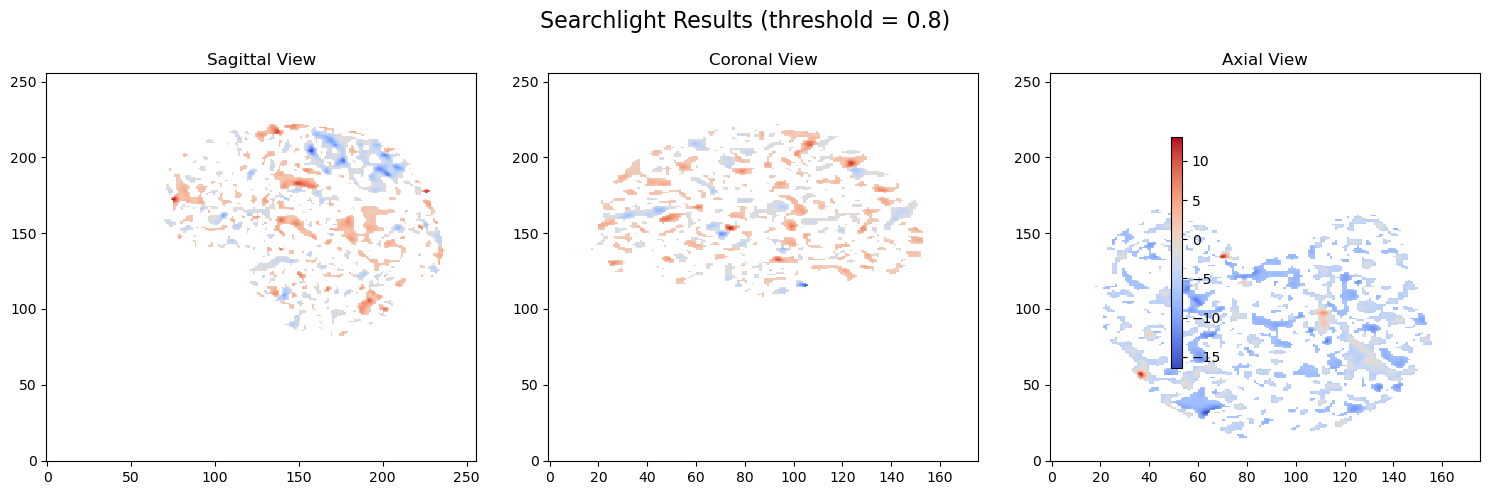

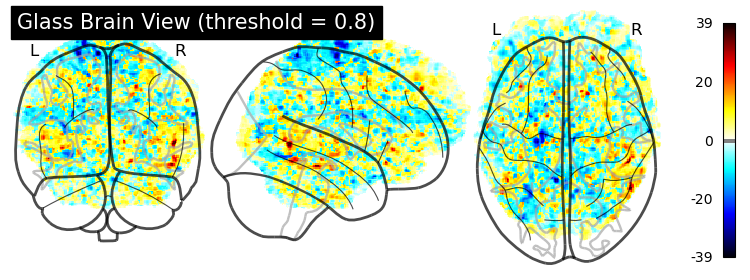

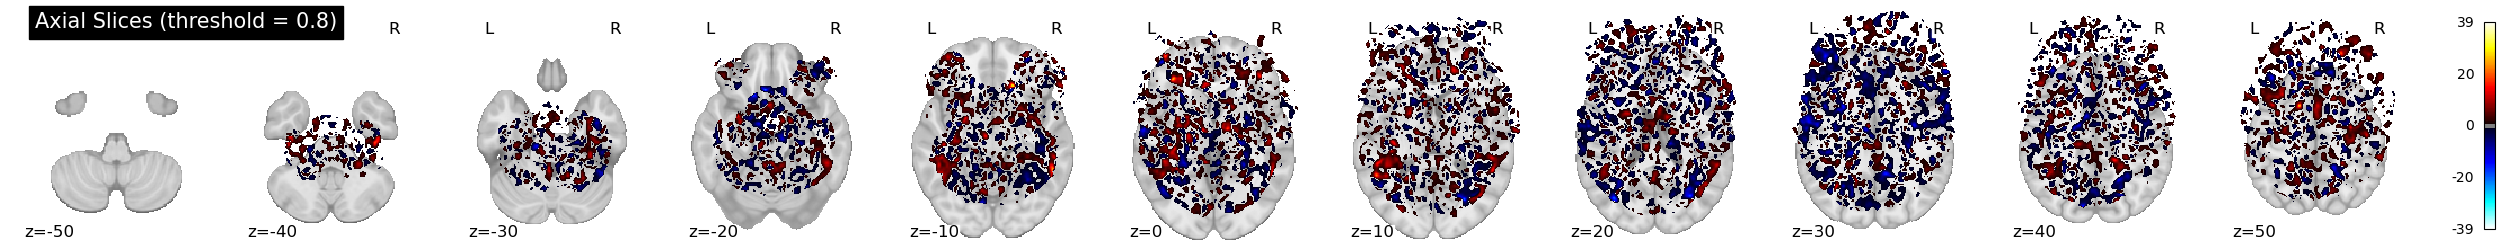

In [3]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting

# File path
file_path = '/lab_data/behrmannlab/vlad/ptoc/sub-025/ses-01/derivatives/gca/searchlight_result_object_run01.nii.gz'

# Set your desired threshold here
threshold = 0.8  # Adjust this value as needed

# Load the NIfTI file
img = nib.load(file_path)
data = img.get_fdata()

# Apply threshold
thresholded_data = np.where(np.abs(data) > threshold, data, np.nan)

# Print basic information
print(f"Image shape: {img.shape}")
print(f"Data type: {data.dtype}")
print(f"Value range: {np.min(data)} to {np.max(data)}")
print(f"Applied threshold: {threshold}")

# Create a figure with multiple subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f'Searchlight Results (threshold = {threshold})', fontsize=16)

# Sagittal view (flip vertically)
sagittal_slice = np.flipud(thresholded_data[img.shape[0]//2, :, :])
im = axes[0].imshow(sagittal_slice.T, cmap='coolwarm', aspect='auto', origin='lower')
axes[0].set_title('Sagittal View')

# Coronal view (flip vertically)
coronal_slice = np.flipud(thresholded_data[:, img.shape[1]//2, :])
axes[1].imshow(coronal_slice.T, cmap='coolwarm', aspect='auto', origin='lower')
axes[1].set_title('Coronal View')

# Axial view (flip vertically)
axial_slice = np.flipud(thresholded_data[:, :, img.shape[2]//2])
axes[2].imshow(axial_slice.T, cmap='coolwarm', aspect='auto', origin='lower')
axes[2].set_title('Axial View')

# Add colorbar
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)

plt.tight_layout()
plt.show()

# Create a 3D plot using nilearn (this should automatically use the correct orientation)
plotting.plot_glass_brain(img, threshold=threshold, colorbar=True, plot_abs=False, 
                          title=f'Glass Brain View (threshold = {threshold})')
plt.show()

# Display a series of axial slices (this should automatically use the correct orientation)
plotting.plot_stat_map(img, threshold=threshold, cut_coords=range(-50, 51, 10), 
                       display_mode='z', title=f'Axial Slices (threshold = {threshold})')
plt.show()

Image shape: (176, 256, 256)
Data type: float64
Value range: -30.177332194763252 to 40.61452576387752


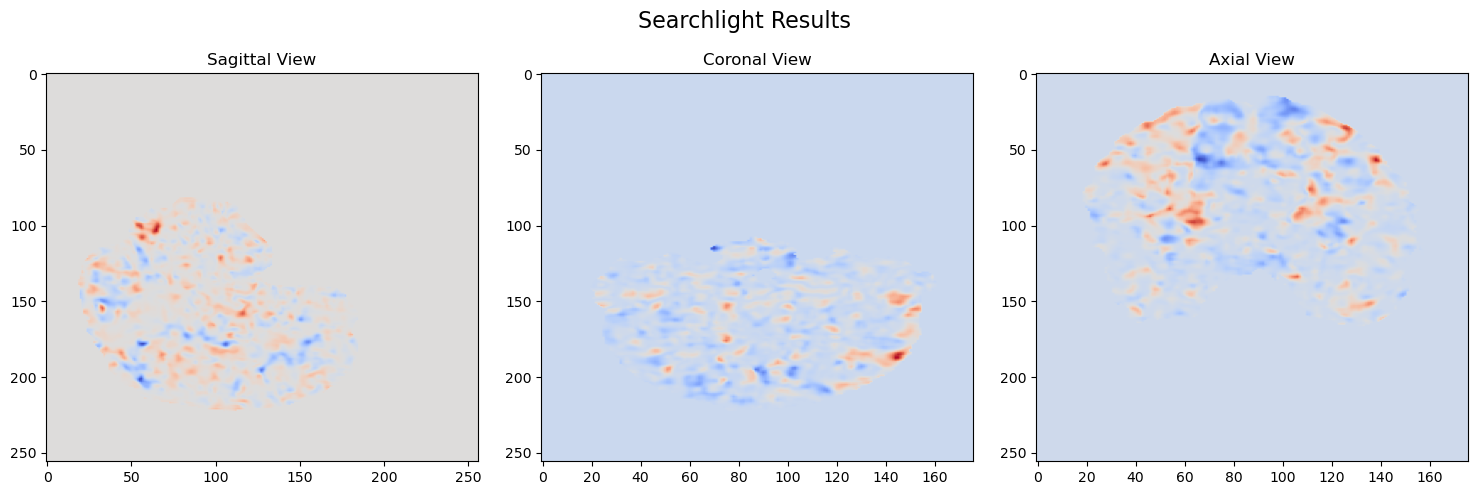

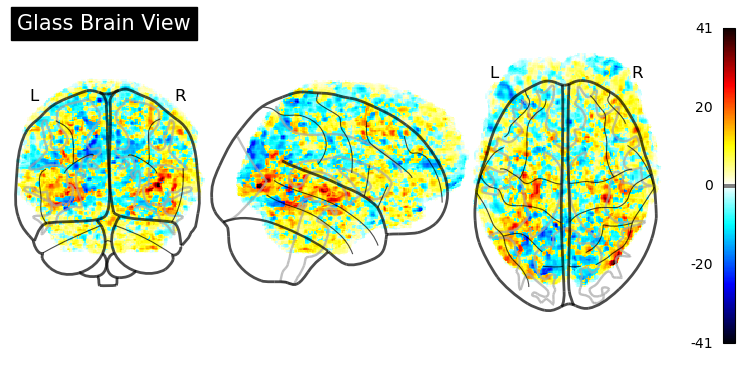

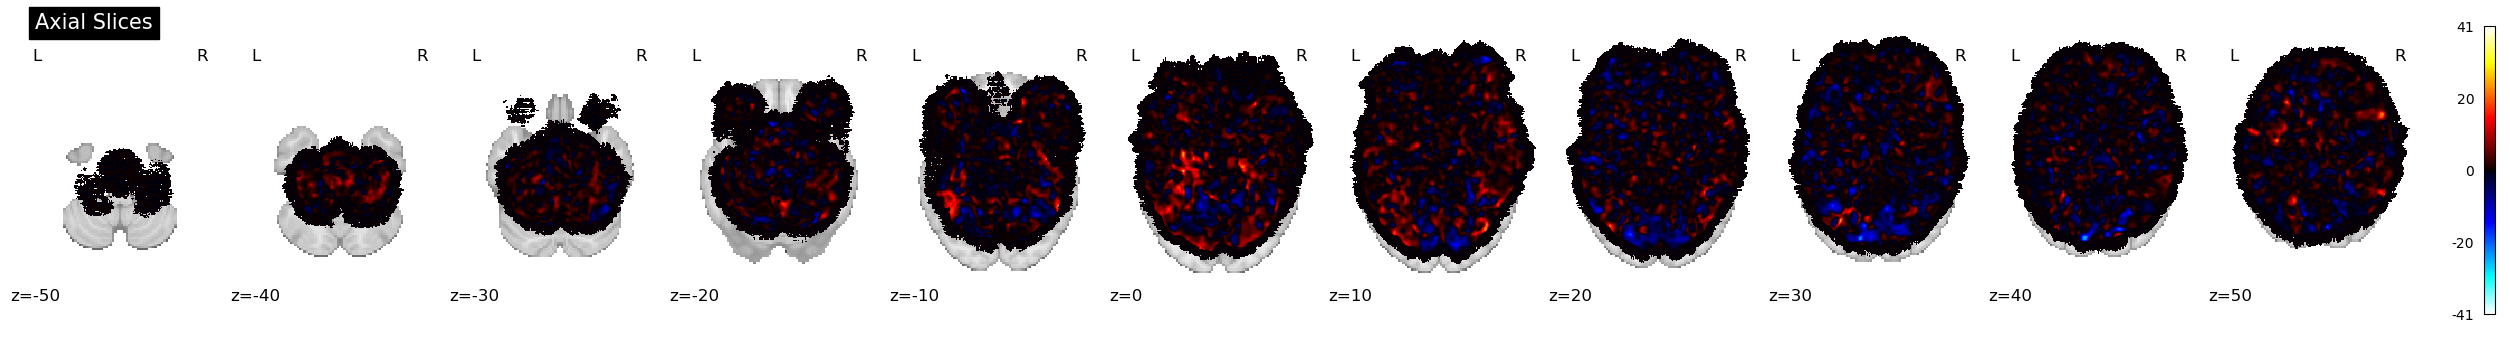

In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting

# File path
file_path = '/lab_data/behrmannlab/vlad/ptoc/sub-025/ses-01/derivatives/gca/searchlight_result_object_runs12_pIPS_left.nii.gz'

# Load the NIfTI file
img = nib.load(file_path)
data = img.get_fdata()

# Print basic information
print(f"Image shape: {img.shape}")
print(f"Data type: {data.dtype}")
print(f"Value range: {np.min(data)} to {np.max(data)}")

# Create a figure with multiple subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Searchlight Results', fontsize=16)

# Sagittal view
sagittal_slice = data[img.shape[0]//2, :, :]
axes[0].imshow(sagittal_slice.T, cmap='coolwarm', aspect='auto')
axes[0].set_title('Sagittal View')

# Coronal view
coronal_slice = data[:, img.shape[1]//2, :]
axes[1].imshow(coronal_slice.T, cmap='coolwarm', aspect='auto')
axes[1].set_title('Coronal View')

# Axial view
axial_slice = data[:, :, img.shape[2]//2]
axes[2].imshow(axial_slice.T, cmap='coolwarm', aspect='auto')
axes[2].set_title('Axial View')

plt.tight_layout()
plt.show()

# Create a 3D plot using nilearn
plotting.plot_glass_brain(img, threshold=0.5, colorbar=True, plot_abs=False, title='Glass Brain View')
plt.show()

# Display a series of axial slices
plotting.plot_stat_map(img, cut_coords=range(-50, 51, 10), display_mode='z', title='Axial Slices')
plt.show()